In [1]:
import numpy as np
import pandas as pd

import pathlib
import os
import sys
import shutil
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

import tensorflow
import tensorflow.keras as k

from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
import zipfile

drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
if not os.path.exists("datasets"):
  os.mkdir("datasets")

with zipfile.ZipFile("/gdrive/MyDrive/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets/gender_original")

In [4]:
main_path = "datasets/gender_original/"
img_path = main_path + "img_align_celeba/img_align_celeba/"

## I- Preprocessing
- cut faces
- resize images to 200x200 px

### 1) Cut faces

In [5]:
image_cut = pd.read_csv(main_path + "list_bbox_celeba.csv")
image_cut.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


On constate que le traitement des images a déjà été fait, toutes les images ont été découpé

### 2) Resize images to 200x200 px

In [6]:
im = Image.open(img_path + '000001.jpg')
im.size

(178, 218)

In [7]:
'''for i in list(pathlib.Path(img_path).glob("*")):
    if Image.open(i).size != (178,218):
        print("different")'''

'for i in list(pathlib.Path(img_path).glob("*")):\n    if Image.open(i).size != (178,218):\n        print("different")'

On constate que le traitement des images a déjà été fait, toutes les images sont de taille **(178,218)**

In [8]:
img_width = 178
img_height = 218

## II- Train-valid-test and gender split

In [9]:
gender_df = pd.read_csv(main_path + "list_attr_celeba.csv")
col = ['image_id','Male']
gender_df = gender_df[col]
gender_df.replace(to_replace = -1, value = 0, inplace = True)
gender_df.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


In [10]:
nb = gender_df.Male.value_counts()
print("Femme: ", nb[0], " => ",round((nb[0]/gender_df.Male.count())*100,2), "%",
      "\nHomme: ", nb[1], " => ",round((nb[1]/gender_df.Male.count())*100,2), "%")

Femme:  118165  =>  58.32 % 
Homme:  84434  =>  41.68 %


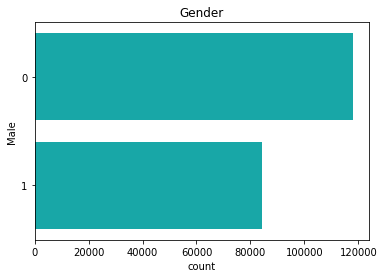

In [11]:
plt.title('Gender')
sns.countplot(y='Male', data=gender_df, color="c")
plt.show()

In [12]:
train_val_test_df = pd.read_csv(main_path + "list_eval_partition.csv")
train_val_test_df.head(5)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [13]:
nb = train_val_test_df.partition.value_counts()
print("Train: ", nb[0], " => ",round((nb[0]/train_val_test_df.partition.count())*100,2), "%",
      "\nValid: ", nb[1], " => ",round((nb[1]/train_val_test_df.partition.count())*100,2), "%",
      "\nTest: ", nb[2], " => ",round((nb[2]/train_val_test_df.partition.count())*100,2), "%")

Train:  162770  =>  80.34 % 
Valid:  19867  =>  9.81 % 
Test:  19962  =>  9.85 %


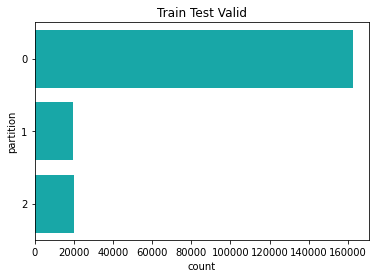

In [14]:
plt.title('Train Test Valid')
sns.countplot(y='partition', data=train_val_test_df, color="c")
plt.show()

In [15]:
df = pd.concat([gender_df, train_val_test_df.drop("image_id", axis=1)],axis=1)
df.head()

,image_id,Male,partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


In [16]:
'''def load_reshape_img(path):
    img = load_img(path)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

def split_dataset(df,partition):
    x = []
    y = []
    for element in tqdm(df.values): 
        if element[2] == partition:
            img = load_reshape_img(img_path + element[0])
            x.append(img)
            y.append(element[1])
    return x,y'''

'def load_reshape_img(path):\n    img = load_img(path)\n    x = img_to_array(img)/255.\n    x = x.reshape((1,) + x.shape)\n\ndef split_dataset(df,partition):\n    x = []\n    y = []\n    for element in tqdm(df.values): \n        if element[2] == partition:\n            img = load_reshape_img(img_path + element[0])\n            x.append(img)\n            y.append(element[1])\n    return x,y'

In [17]:
len(list(pathlib.Path("datasets/gender/").glob('*')))

0

In [27]:
def split_dataset(df,partition,name):
    path = "datasets/gender/"
    if not os.path.exists(path+name):
        os.mkdir(path+name)
    if not os.path.exists(path+name+"/Men"):
        os.mkdir(path+name+"/Men")
    if not os.path.exists(path+name+"/Women"):
        os.mkdir(path+name+"/Women")
        
    try:
      for element in tqdm(df.values): 
        if element[2] == partition:
          if element[1] == 1:
            shutil.copy(img_path + element[0],path+name+"/Men/"+ element[0])
          else:
            shutil.copy(img_path + element[0],path+name+"/Women/"+ element[0])
    except:
      print(df)

In [29]:
if not os.path.exists("datasets/gender"):
    os.mkdir("datasets/gender")
split_dataset(df,0,"training_set")
split_dataset(df,1,"validation_set")
split_dataset(df,2,"test_set")

## III- Image augmentation

In [65]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('datasets/gender/training_set',
                                                 target_size = (178,218),
                                                 batch_size = 16)

validation_set = test_datagen.flow_from_directory('datasets/gender/validation_set',
                                            target_size = (178,218),
                                            batch_size = 16)

test_set = test_datagen.flow_from_directory('datasets/gender/test_set',
                                            target_size = (178,218),
                                            batch_size = 16)

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


## IV- Create the model

In [61]:
#Importation de modules Keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

# Initialiser le CNN
gender_net = Sequential()

# Etape 1: Convolution
gender_net.add(Conv2D(filters = 32, kernel_size = 3, input_shape = (178, 218, 3), activation = "relu"))
gender_net.add(MaxPooling2D()) # Etape 2 - Pooling

gender_net.add(Conv2D(64, 3, activation = "relu"))
gender_net.add(MaxPooling2D(pool_size=(2,2)))

gender_net.add(Conv2D(64, 3, activation = "relu"))
gender_net.add(MaxPooling2D(pool_size=(2,2)))
gender_net.add(Dropout(rate = 0.5))

gender_net.add(Conv2D(128, 3, activation = "relu"))
gender_net.add(MaxPooling2D(pool_size=(2,2)))
gender_net.add(Dropout(rate = 0.5))

gender_net.add(Conv2D(128, 3, activation = "relu"))
gender_net.add(MaxPooling2D(pool_size=(2,2)))
gender_net.add(Dropout(rate = 0.5))

# Etape 3 - Flattening
gender_net.add(Flatten())

# Etape 4 - Couche complétement connectée
gender_net.add(Dense(units = 64, activation = 'relu'))
gender_net.add(Dense(2, activation="softmax"))

In [62]:
gender_net.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 176, 216, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 88, 108, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 86, 106, 64)       18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 53, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 43, 53, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 51, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 25, 64)       

In [67]:
gender_net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#gender_net.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='gender_net.h5', 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
'''gender_net.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)'''

## V- Fit the model

In [70]:
hist = gender_net.fit(training_set,
                         steps_per_epoch = 250,
                         epochs = 25,
                         validation_data = validation_set)#,
                         #validation_steps = 63)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
250/250 [==============================] - 587s 2s/step - loss: 0.6778 - accuracy: 0.5740 - val_loss: 0.6653 - val_accuracy: 0.6045
Epoch 2/25
250/250 [==============================] - 581s 2s/step - loss: 0.6179 - accuracy: 0.6597 - val_loss: 0.6495 - val_accuracy: 0.7055
Epoch 3/25
250/250 [==============================] - 573s 2s/step - loss: 0.5859 - accuracy: 0.7085 - val_loss: 0.5400 - val_accuracy: 0.7495
Epoch 4/25
250/250 [==============================] - 575s 2s/step - loss: 0.5421 - accuracy: 0.7340 - val_loss: 0.5160 - val_accuracy: 0.7831
Epoch 5/25
250/250 [==============================] - 569s 2s/step - loss: 0.4795 - accuracy: 0.7795 - val_loss: 0.4164 - val_accuracy: 0.8256
Epoch 6/25
250/250 [==============================] - 572s 2s/step - loss: 0.4421 - accuracy: 0.7960 - val_loss: 0.3575 - val_accuracy: 0.8581
Epoch 7/25
250/250 [==============================] - 572s 2s/step - loss: 0.4043 - accuracy: 0.8102 - val_loss: 0.3339 - val_accuracy: 0.8713

In [ ]:
#hist = model.fit(images_train, targets_train, epochs=50, validation_split=0.2)

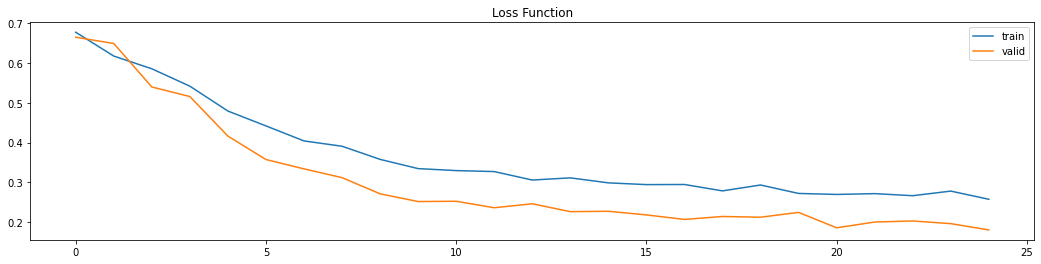

In [71]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

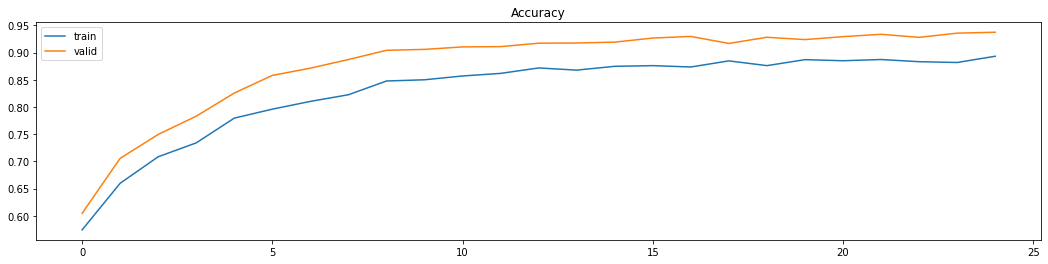

In [73]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [74]:
if not os.path.exists("Models"):
    os.mkdir("Models")
gender_net.save("Models/gender_net.h5")

## VI- Use the model

In [76]:
loaded_model = k.models.load_model("Models/gender_net.h5")

In [95]:
result = loaded_model.evaluate(test_set)

1248/1248 [==============================] - 344s 275ms/step - loss: 0.1924 - accuracy: 0.9308
loss :  0.19239602982997894 
 accuracy :  0.9308185577392578


In [97]:
print(loaded_model.metrics_names[0], ": ", round(result[0],4),"\n", 
      loaded_model.metrics_names[1], ": ", round(result[1]*100,2)," %", sep="")

loss: 0.1924
accuracy: 93.08%


In [ ]:
def load_reshape_img(path):
    img = load_img(path)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

def load__img(df):
    x = []
    y = []
    for element in tqdm(df.values): 
        if element[2] == partition:
            img = load_img(img_path + element[0])
            x.append(img)
            y.append(element[1])
    return x,y

In [ ]:
prediction = loaded_model.predict(image)
print(prediction)
if prediction == 0:
  print("Femme")
else:
  print("Homme")